# Analyzing [Stack Overflow Annual Developer Surveys](https://insights.stackoverflow.com/survey).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999

#### Setup surveys dictionary for an easy access to all the surveys' data

In [3]:
surveys = {
    "2011": {
        "data": "2011 Stack Overflow Survey Results/2011 Stack Overflow Survey Results.csv",
        "readme": None,
        "schema": None
    },
    "2012": {
        "data": "2012 Stack Overflow Survey Results/2012 Stack Overflow Survey Results.csv",
        "readme": None,
        "schema": None
    },
    "2013": {
        "data": "2013 Stack Overflow Survey Responses/2013 Stack Overflow Survey Responses.csv",
        "readme": None,
        "schema": None
    },
    "2014": {
        "data": "2014 Stack Overflow Survey Responses/2014 Stack Overflow Survey Responses.csv",
        "readme": None,
        "schema": None
    },
    "2015": {
        "data": "2015 Stack Overflow Developer Survey Responses/2015 Stack Overflow Developer Survey Responses.csv",
        "readme": None,
        "schema": None
    },
    "2016": {
        "data": "2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Responses.csv",
        "readme": "2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Results/READ_ME_-_The_Public_2016_Stack_Overflow_Developer_Survey_Results.txt",
        "schema": None
    },
    "2017": {
        "data": "developer_survey_2017/survey_results_public.csv",
        "readme": "developer_survey_2017/README_2017.txt",
        "schema": "developer_survey_2017/survey_results_schema.csv"
    },
    "2018": {
        "data": "developer_survey_2018/survey_results_public.csv",
        "readme": "developer_survey_2018/README_2018.txt",
        "schema": "developer_survey_2018/survey_results_schema.csv"
    },
    "2019": {
        "data": "developer_survey_2019/survey_results_public.csv",
        "readme": "developer_survey_2019/README_2019.txt",
        "schema": "developer_survey_2019/survey_results_schema.csv"
    },
    "2020": {
        "data": "developer_survey_2020/survey_results_public.csv",
        "readme": "developer_survey_2020/README_2020.txt",
        "schema": "developer_survey_2020/survey_results_schema.csv"
    }
}

#### Setup functions for searching columns for keywords

In [4]:
def search_schema(df, string):
    """Search schema's DataFrame columns 'Question' for the word match.
    Args:
        df (pandas.DataFrame):
        string (str):
    Returns:
        DataFrame containing labels and questions with the matched word.
    """
    if 'Question' in df.columns:
        return df[df['Question'].str.contains('\W*'+string+'\W*', case=False, regex=True)]
    return df[df['QuestionText'].str.contains('\W*'+string+'\W*', case=False, regex=True)]

def search_columns(df, string):
    """Search DataFrame's columns for the word match.
    Args:
        df (pandas.DataFrame):
        string (str):
    Returns:
        List containing all the columns with the word match.
    """
    return df.columns[df.columns.str.contains('\W*'+string+'\W*', case=False, regex=True)].tolist()

In [39]:
# This is example how `search_schema` works and the description of a column with the subject of study "LanguageWorkedWith"
search_schema(pd.read_csv(surveys['2020']['schema']), 'lang')

,Column,QuestionText
21,LanguageDesireNextYear,"Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)"
22,LanguageWorkedWith,"Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)"
32,NEWLearn,How frequently do you learn a new language or framework?


In [40]:
# Description of a column with the subject of study "JobSat"
search_schema(pd.read_csv(surveys['2020']['schema']), 'sat')

,Column,QuestionText
5,CompFreq,"Is that compensation weekly, monthly, or yearly?"
6,CompTotal,"What is your current total compensation (salary, bonuses, and perks, before taxes and deductions), in `CurrencySymbol`? Please enter a whole number in the box below, without any punctuation. If you are paid hourly, please estimate an equivalent weekly, monthly, or yearly salary. If you prefer not to answer, please leave the box empty."
18,JobFactors,"Imagine that you are deciding between two job offers with the same compensation, benefits, and location. Of the following factors, which 3 are MOST important to you?"
19,JobSat,"How satisfied are you with your current job? (If you work multiple jobs, answer for the one you spend the most hours on.)"


In [44]:
survey_2017 = pd.read_csv(surveys['2017']['data'], low_memory=True)
survey_2017.shape

(51392, 154)

In [42]:
# This is example how `search_columns` works and all the columns in the data set containing substring "sat" in their names
search_columns(survey_2017, 'sat')

['CareerSatisfaction',
 'JobSatisfaction',
 'AssessJobCompensation',
 'EquipmentSatisfiedMonitors',
 'EquipmentSatisfiedCPU',
 'EquipmentSatisfiedRAM',
 'EquipmentSatisfiedStorage',
 'EquipmentSatisfiedRW',
 'StackOverflowSatisfaction']

### How does it feel like to earn 10k or 200k as a programmer? Let's explore!

While inspecting data sets my attention was caught by "Overpaid" column, *latest data set that "Overpaid" column is 2017*

In [55]:
intervals = [i for i in range(10000, 100001, 10000)] + [i for i in range(120000, 200001, 20000)]

def process_salary(df):
    dataframe = df.copy()
    dataframe = dataframe.dropna(subset=['Salary'], axis=0)
    dataframe['Salary'] = dataframe['Salary'].apply(lambda x: intervals[np.argmin(abs(np.array(intervals) - x))])
    return dataframe

def process_overpaid(df):
    dataframe = df.copy()
    dataframe['Overpaid'] = dataframe['Overpaid'].fillna('Not sure')
    return dataframe

def make_dummies(df, col):
    dataframe = pd.get_dummies(df, columns=[col])
    return dataframe

survey_2017_clean = survey_2017.copy()
survey_2017_clean = process_salary(survey_2017_clean)
survey_2017_clean = process_overpaid(survey_2017_clean)
overpaid_list = ['Overpaid_'+i for i in survey_2017_clean['Overpaid'].unique()]
survey_2017_clean = make_dummies(survey_2017_clean, 'Overpaid')

In [53]:
overpaid_list

['Overpaid_Neither underpaid nor overpaid',
 'Overpaid_Somewhat underpaid',
 'Overpaid_Somewhat overpaid',
 'Overpaid_Greatly underpaid',
 'Overpaid_Not sure',
 'Overpaid_Greatly overpaid']

In [56]:
overpaid_dict = {
    "Overpaid_Greatly underpaid": "Greatly underpaid",
    "Overpaid_Somewhat underpaid": "Somewhat underpaid",
    "Overpaid_Neither underpaid nor overpaid": "Neither",
    "Overpaid_Somewhat overpaid": "Somewhat overpaid",
    "Overpaid_Greatly overpaid": "Greatly overpaid",
    "Overpaid_Not sure": "Not sure",
}

In [67]:
salary_overpaid_2017 = survey_2017_clean[['Salary']+overpaid_list].groupby(by='Salary').sum()
salary_overpaid_2017

,Overpaid_Neither underpaid nor overpaid,Overpaid_Somewhat underpaid,Overpaid_Somewhat overpaid,Overpaid_Greatly underpaid,Overpaid_Not sure,Overpaid_Greatly overpaid
Salary,,,,,,
10000,603.0,928.0,86.0,457.0,17.0,21.0
20000,295.0,466.0,43.0,156.0,1.0,10.0
30000,356.0,590.0,71.0,193.0,4.0,5.0
40000,481.0,678.0,66.0,163.0,1.0,8.0
50000,534.0,721.0,62.0,164.0,2.0,7.0
60000,474.0,592.0,88.0,121.0,2.0,4.0
70000,334.0,435.0,57.0,68.0,1.0,1.0
80000,285.0,334.0,43.0,44.0,1.0,7.0
90000,265.0,271.0,55.0,31.0,1.0,3.0


In [68]:
salary_overpaid_2017['Total'] = salary_overpaid_2017.sum(axis=1)
total = salary_overpaid_2017['Total'].sum()
salary_overpaid_2017['Total, %'] = salary_overpaid_2017['Total'] * 100 / total
salary_overpaid_2017

,Overpaid_Neither underpaid nor overpaid,Overpaid_Somewhat underpaid,Overpaid_Somewhat overpaid,Overpaid_Greatly underpaid,Overpaid_Not sure,Overpaid_Greatly overpaid,Total,"Total, %"
Salary,,,,,,,,
10000,603.0,928.0,86.0,457.0,17.0,21.0,2112.0,16.383523
20000,295.0,466.0,43.0,156.0,1.0,10.0,971.0,7.532387
30000,356.0,590.0,71.0,193.0,4.0,5.0,1219.0,9.456210
40000,481.0,678.0,66.0,163.0,1.0,8.0,1397.0,10.837018
50000,534.0,721.0,62.0,164.0,2.0,7.0,1490.0,11.558452
60000,474.0,592.0,88.0,121.0,2.0,4.0,1281.0,9.937165
70000,334.0,435.0,57.0,68.0,1.0,1.0,896.0,6.950586
80000,285.0,334.0,43.0,44.0,1.0,7.0,714.0,5.538748
90000,265.0,271.0,55.0,31.0,1.0,3.0,626.0,4.856101


In [60]:
def convert_xticks(arr, rank=1000, label='k'):
    result = map(lambda x: str(x//rank)+label, arr)
    return list(result)

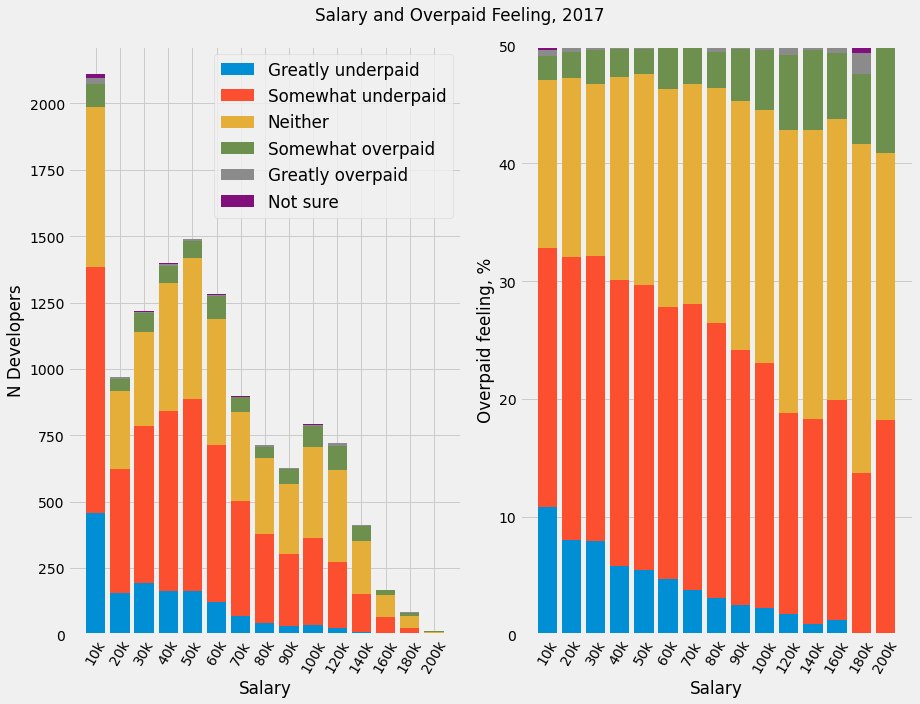

In [61]:
bottom = len(intervals) * [0]
ticks = np.arange(len(intervals))
labels = convert_xticks(intervals)

plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,10))
for overpaid in overpaid_dict:
    axes[0].bar(ticks, salary_overpaid_2017[overpaid], bottom=bottom)
    bottom += salary_overpaid_2017[overpaid]
    
axes[0].set_xlabel('Salary')
axes[0].set_ylabel('N Developers')
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(labels, rotation=60)
axes[0].legend(labels=overpaid_dict.values(), fontsize='large')

bottom = len(intervals) * [0]
for overpaid in overpaid_dict:
    row = salary_overpaid_2017[overpaid] * 100 / salary_overpaid_2017['Total']
    axes[1].bar(ticks, row, bottom=bottom)
    bottom += row
    
axes[1].set_xlabel('Salary')
axes[1].set_ylabel('Overpaid feeling, %')
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(labels, rotation=60)
axes[1].legend([]).set_visible(False)

fig.suptitle('Salary and Overpaid Feeling, 2017')

fig.tight_layout()
plt.show()

In [109]:
salary_overpaid_2017.loc[:, 'Total, %'].cumsum()

Salary
10000      16.383523
20000      23.915910
30000      33.372120
40000      44.209138
50000      55.767590
60000      65.704755
70000      72.655341
80000      78.194089
90000      83.050190
100000     89.186254
120000     94.779303
140000     97.959817
160000     99.263052
180000     99.914669
200000    100.000000
Name: Total, %, dtype: float64

- Most programmers ~89% earn upto 100k. The biggest cluster is 10k salary and ~16% of all programmers. Salary that starts of 140k is rare and only ~2%.
- It is not a secret that underpaid feeling is the greatest among developers with lower salaries. What is interesting is the curve of how this feeling is decreasing while salary is approaching the top values.
    - Can clearly see the steps on the percentage scale from 10k to 30k included, then it drops to the next range from 40k to 50k included, then the next step is from 60k to 70k included and then start to drop until next stop at 100k to 160k

## Exploring Language* by Job and Career Satisfaction

\**Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year?*

#### Setup functions for cleaning datasets

In [13]:
def strlist_to_dummies(col, sep=";"):
    """Convert strings, containing separated values in pd.series to pd.dummies.
    
    Args:
      col (Pandas.Series): Column with lists, that will be separated and exploded.
      sep (str): Separator of the list values.
      
    Returns:
      Pandas.DataFrame dummies.
    """
    # Converting separated values from single string to list
    splitted = col.str.split(sep)
    # Removing unnecessary leading/trailing spaces and handling NAN cases
    stripped = splitted.apply(lambda x: [i.strip() for i in x] if type(x) is list else x)
    explode = stripped.explode()
    dummies = pd.get_dummies(explode)
    return dummies.sum(level=0)

def group_sat_lang(df, sat, lang, cols_sorted, mapping=None):
    df_ = df.copy()
    df_ = df_.dropna(subset=[sat, lang], axis=0)
    if mapping:
        df_[sat] = df_[sat].map(mapping)
    dummies = strlist_to_dummies(df_[lang])
    df_ = pd.concat([df_[sat], dummies], axis=1)
    median = len(cols_sorted) // 2
    sat_select = cols_sorted[-median:] if "dissatisfied" in cols_sorted[0] else cols_sorted[:median]
    dis_select = cols_sorted[:median] if "dissatisfied" in cols_sorted[0] else cols_sorted[-median:]
    groupped = df_.groupby(by=sat).sum().T
    groupped = groupped[cols_sorted]
    groupped['Total'] = groupped.sum(axis=1)
    groupped['Satisfaction'] = groupped[sat_select].sum(axis=1) / groupped['Total']
    groupped['Dissatisfaction'] = groupped[dis_select].sum(axis=1) / groupped['Total']
    groupped['Sat_Net'] = groupped['Satisfaction'] - groupped['Dissatisfaction']
    return groupped

#### Setup functions for barh plot

In [36]:
def calc_abs_scale(arr):
    maximum = int(np.max(arr))
    rank = pow(10, int(math.log10(maximum)))
    # Rounding integer to the next rank
    maximum_adj = int(np.ceil(maximum/rank)*rank)
    max_steps = 10
    step = int(maximum_adj/max_steps)
    scale = {}
    for i in range(0, maximum+step+1, step):
        scale[str(i)] = i
    return scale

def calc_pct_scale(step=10):
    scale = {}
    for i in range(0, 101, step):
        scale[str(i)] = i
    # Checking that 100% is included
    last_num = list(scale.values())[-1]
    if last_num != 100:
        scale[str(100)] = 100
    return scale

def plot_satisfaction_barh(df, sat, year, cols_sorted, style='fivethirtyeight'):
    """Plot language recently worked with by satisfaction (job/career) barh.
    
    Args:
      df (pandas.DataFrame): Dataset.
      sat (str): 'Job'/'Career' for the title.
      year (al/num): Year of the dataset for the title.
      cols_sorted (list): Names of the satisfaction columns.
      style (str): Plt style.
    
    Returns: Nothing.
    """
    plt.style.use(style)

    fig = plt.figure(figsize=(13, 10))

    gs = fig.add_gridspec(1,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    lang_sat = df.copy()
    lang_sat = lang_sat.sort_values(by='Total', ascending=False)

    left = lang_sat.shape[0] * [0]
    for column in cols_sorted:
        ax1.barh(lang_sat.index.tolist(), lang_sat[column], left=left)
        left += lang_sat[column]

    ax1.set_xlabel('N Developers')
    ax1.set_ylabel('Language Recently Worked With')
    scale = calc_abs_scale(lang_sat['Total'])
    ax1.set_xticks(list(scale.values()))
    ax1.set_xticklabels(list(scale.keys()))
    ax1.tick_params(axis='x', labelrotation=45)
    labels = ['Neither' if 'Neither' in i else i for i in cols_sorted]
    ax1.legend(labels=labels, fontsize='large', loc='upper right')
    
    lang_sat_pct = df.copy()
    lang_sat_pct = lang_sat_pct.sort_values(by='Sat_Net', ascending=False)

    left = lang_sat_pct.shape[0] * [0]
    for column in cols_sorted:
        row = lang_sat_pct[column] * 100 / lang_sat_pct['Total']
        ax2.barh(lang_sat_pct.index.tolist(), row, left=left)
        left += row

    ax2.set_xlabel(f'{sat} Satisfaction, %')
    ax2.set_ylabel('Language Recently Worked With')
    scale_pct = calc_pct_scale()
    ax2.set_xticks(list(scale_pct.values()))
    ax2.set_xticklabels(list(scale_pct.keys()))
    ax2.tick_params(axis='x', labelrotation=45)
    ax2.legend([]).set_visible(False)

    fig.suptitle(f'{sat} Satisfaction and Language Recently Worked With, {year}')

    fig.tight_layout()
    plt.show()

#### Setup functions for scatter plot

In [15]:
def calc_scatter_lims(df_x, df_y, padding=2):
    lim_min_raw = min(df_x.loc[:, 'Satisfaction'].min(), df_y.loc[:, 'Satisfaction'].min())
    lim_min = math.floor(lim_min_raw*100-padding)/100
    lim_max_raw = max(df_x.loc[:, 'Satisfaction'].max(), df_y.loc[:, 'Satisfaction'].max())
    lim_max = math.ceil(lim_max_raw*100+padding)/100
    return lim_min, lim_max

def plot_satisfaction_scatter(df_x, df_y, xlabel, ylabel, title):
    markers = ['s', 'p', 'D', 'o', 'X', '+', 'v', '^', '<', '>', '.', ',']
    size_coef = lambda x: (df_x.loc[x, 'Total'] + df_y.loc[x, 'Total']) / \
                            (df_x.loc[:, 'Total'].max() + df_y.loc[:, 'Total'].max())

    languages = sorted(df_x.index)
    plt.figure(figsize=(10, 10))
    for lang, marker in zip(languages, markers):
        x = df_x.loc[lang, 'Satisfaction']
        y = df_y.loc[lang, 'Satisfaction']
        plt.scatter(x, y, marker=marker, alpha=0.8, s=1000*size_coef(lang))
        
    min_lim, max_lim = calc_scatter_lims(df_x, df_y)
    plt.xlim(min_lim, max_lim)
    plt.ylim(min_lim, max_lim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(languages, fontsize='large', loc='lower right')
    plt.title(title)
    plt.show()

In [16]:
survey_2018 = pd.read_csv(surveys['2018']['data'], low_memory=False)
# print(survey_2018.shape, survey_2018.columns.tolist())

In [17]:
survey_2019 = pd.read_csv(surveys['2019']['data'], low_memory=False)
# print(survey_2019.shape, survey_2019.columns.tolist())

In [18]:
survey_2020 = pd.read_csv(surveys['2020']['data'], low_memory=False)
# print(survey_2020.shape, survey_2020.columns.tolist())

### Exploring 2017 year survey data

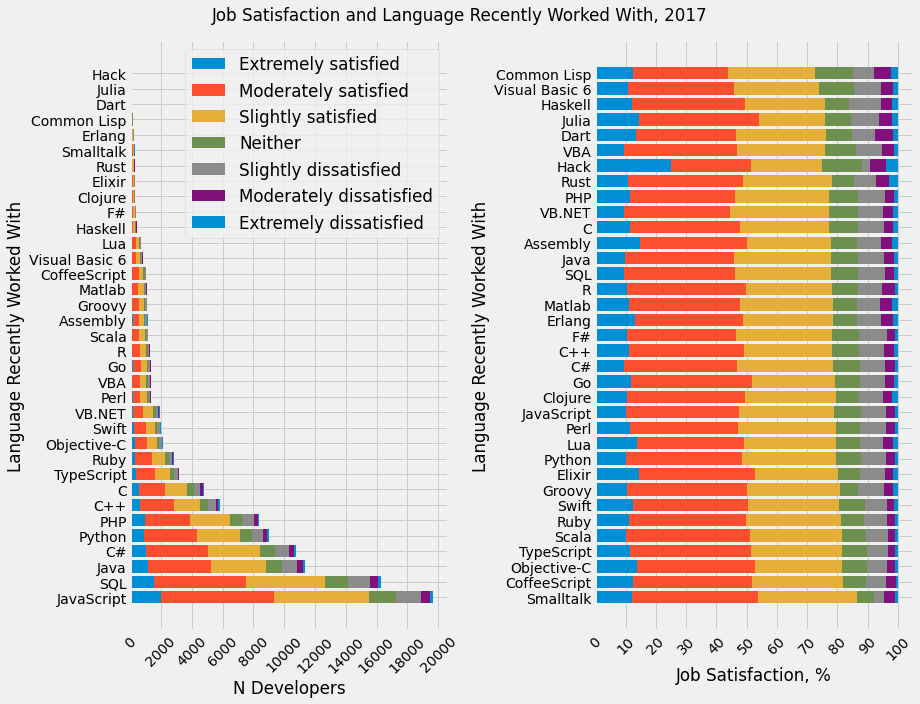

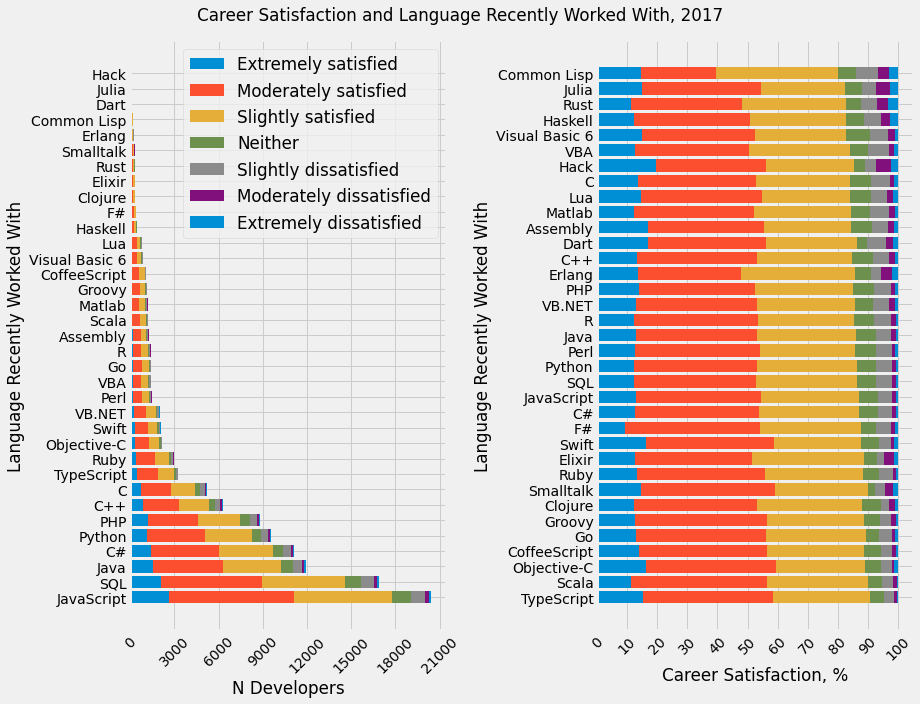

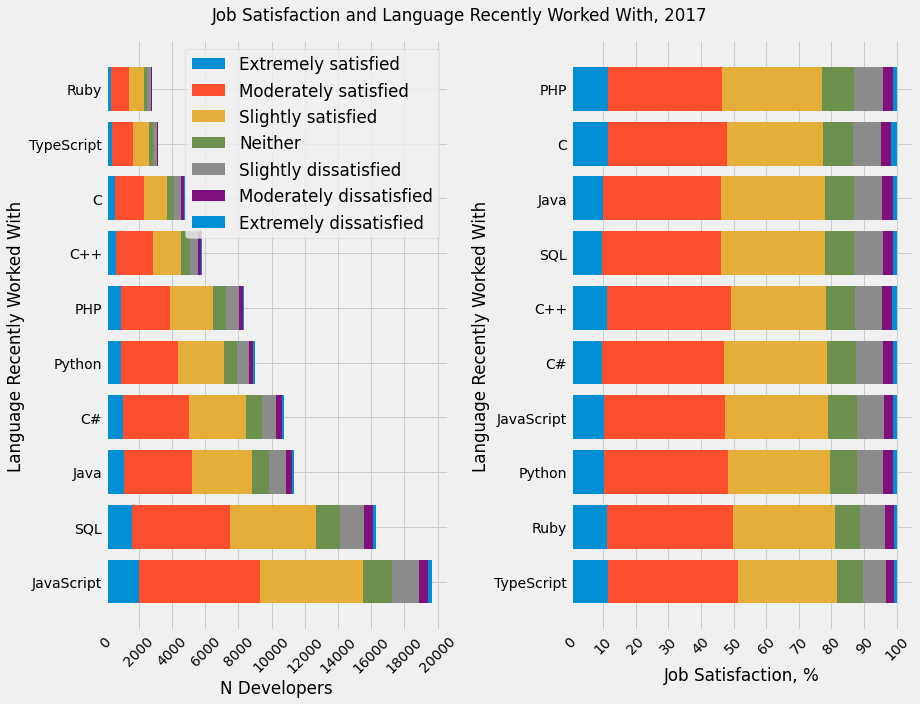

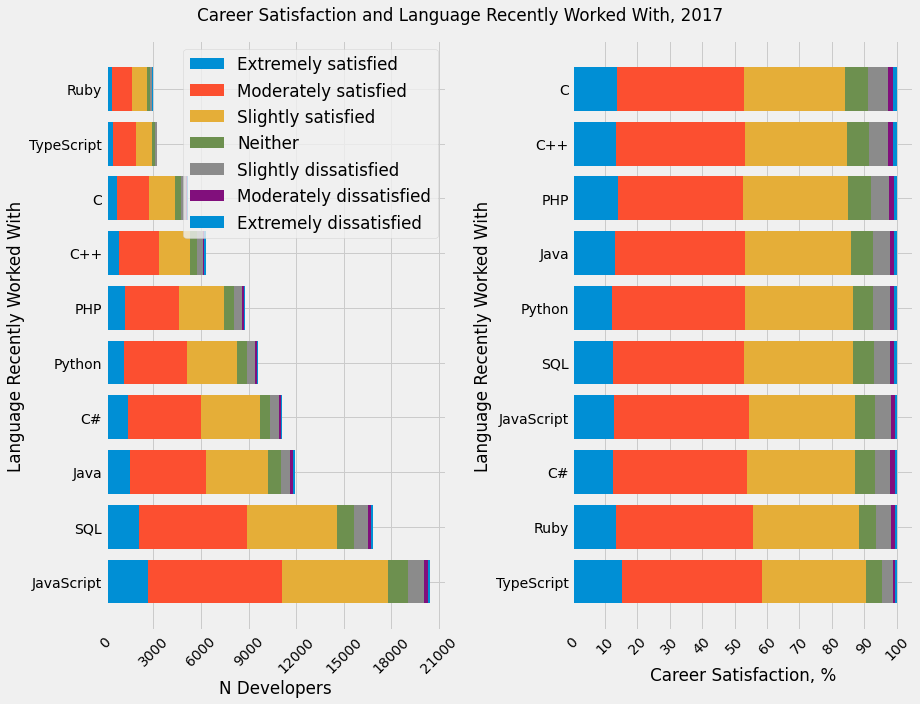

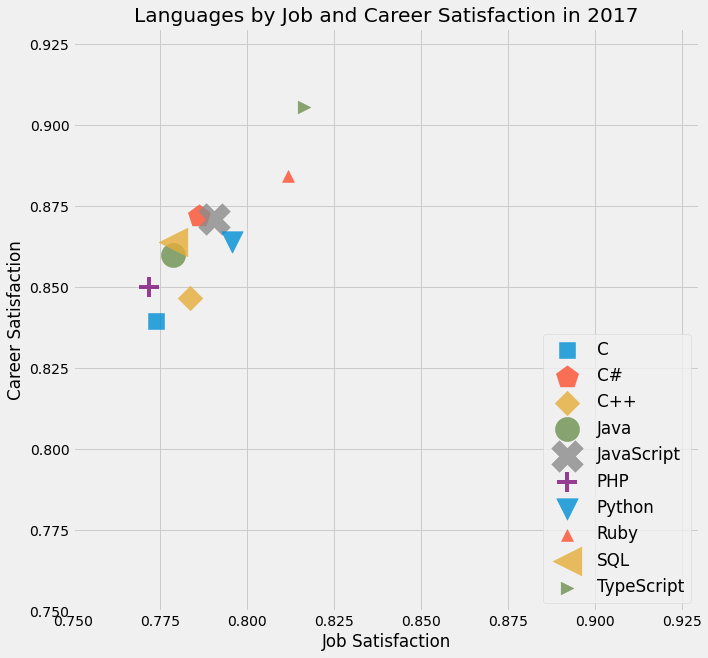

In [37]:
mapping_2017 = {
    10: 'Extremely satisfied',
    9: 'Moderately satisfied',
    8: 'Moderately satisfied',
    7: 'Slightly satisfied',
    6: 'Slightly satisfied',
    5: 'Neither satisfied nor dissatisfied',
    4: 'Slightly dissatisfied',
    3: 'Slightly dissatisfied',
    2: 'Moderately dissatisfied',
    1: 'Moderately dissatisfied',
    0: 'Extremely dissatisfied'
}

columns_sorted_2017 = [
    'Extremely satisfied',
    'Moderately satisfied',
    'Slightly satisfied',
    'Neither satisfied nor dissatisfied',
    'Slightly dissatisfied',
    'Moderately dissatisfied',
    'Extremely dissatisfied',
]

language_job_satisfaction_2017 = group_sat_lang(survey_2017, 'JobSatisfaction', 'HaveWorkedLanguage', columns_sorted_2017, mapping_2017)
language_career_satisfaction_2017 = group_sat_lang(survey_2017, 'CareerSatisfaction', 'HaveWorkedLanguage', columns_sorted_2017, mapping_2017)

plot_satisfaction_barh(language_job_satisfaction_2017, 'Job', '2017', columns_sorted_2017)
plot_satisfaction_barh(language_career_satisfaction_2017, 'Career', '2017', columns_sorted_2017)


"""
Exploring top 10 most used languages in 2017
"""
# Languages by job satisfaction
ljs_2017_total_top_10 = language_job_satisfaction_2017.loc[language_job_satisfaction_2017['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(ljs_2017_total_top_10, 'Job', '2017', columns_sorted_2017)

# Languages by career satisfaction
lcs_2017_total_top_10 = language_career_satisfaction_2017.loc[language_career_satisfaction_2017['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(lcs_2017_total_top_10, 'Career', '2017', columns_sorted_2017)

plot_satisfaction_scatter(ljs_2017_total_top_10, lcs_2017_total_top_10, 
                          'Job Satisfaction', 'Career Satisfaction', 
                          'Languages by Job and Career Satisfaction in 2017')

### 

In [22]:
language_job_satisfaction_2017

JobSatisfaction,Extremely satisfied,Moderately satisfied,Slightly satisfied,Neither satisfied nor dissatisfied,Slightly dissatisfied,Moderately dissatisfied,Extremely dissatisfied,Total,Satisfaction,Dissatisfaction,Sat_Net
Assembly,167.0,400.0,315.0,98.0,89.0,40.0,23.0,1132.0,0.779152,0.134276,0.644876
C,552.0,1737.0,1410.0,445.0,411.0,148.0,76.0,4779.0,0.774011,0.132873,0.641138
C#,1026.0,4011.0,3407.0,964.0,883.0,335.0,115.0,10741.0,0.786147,0.124104,0.662043
C++,641.0,2207.0,1702.0,515.0,482.0,181.0,78.0,5806.0,0.783672,0.127627,0.656045
Clojure,35.0,131.0,101.0,26.0,27.0,10.0,6.0,336.0,0.794643,0.127976,0.666667
CoffeeScript,129.0,412.0,316.0,78.0,70.0,34.0,6.0,1045.0,0.820096,0.105263,0.714833
Common Lisp,22.0,55.0,51.0,22.0,12.0,10.0,4.0,176.0,0.727273,0.147727,0.579545
Dart,16.0,39.0,35.0,10.0,9.0,7.0,2.0,118.0,0.762712,0.152542,0.610169
Elixir,48.0,126.0,90.0,24.0,27.0,9.0,5.0,329.0,0.802432,0.124620,0.677812
Erlang,30.0,82.0,68.0,18.0,18.0,9.0,4.0,229.0,0.786026,0.135371,0.650655


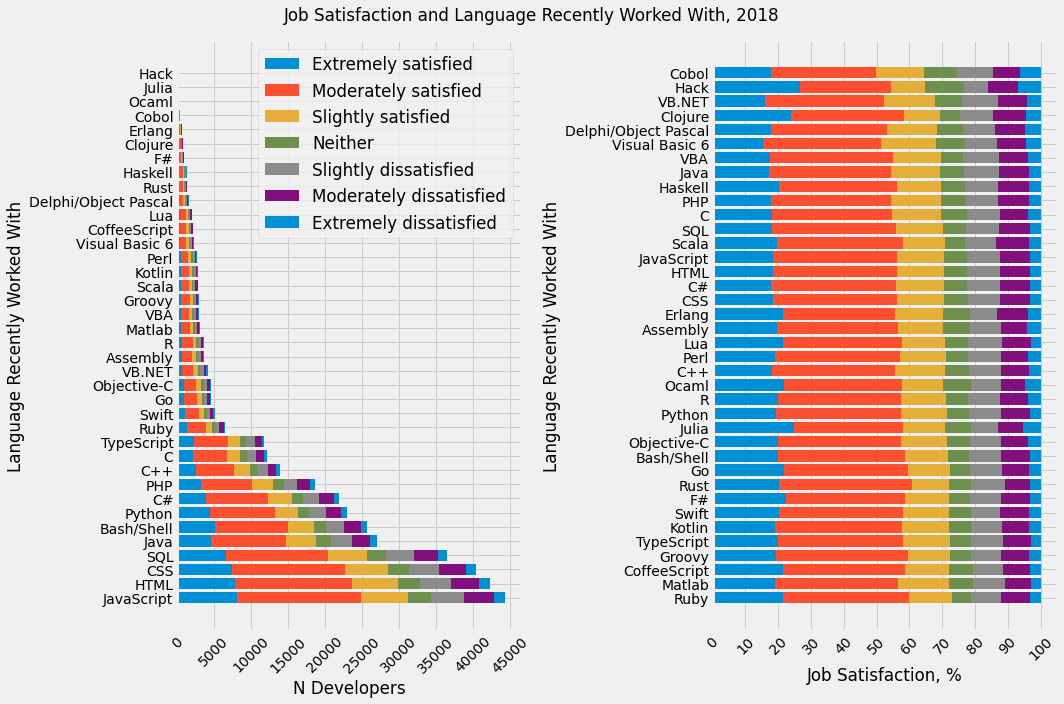

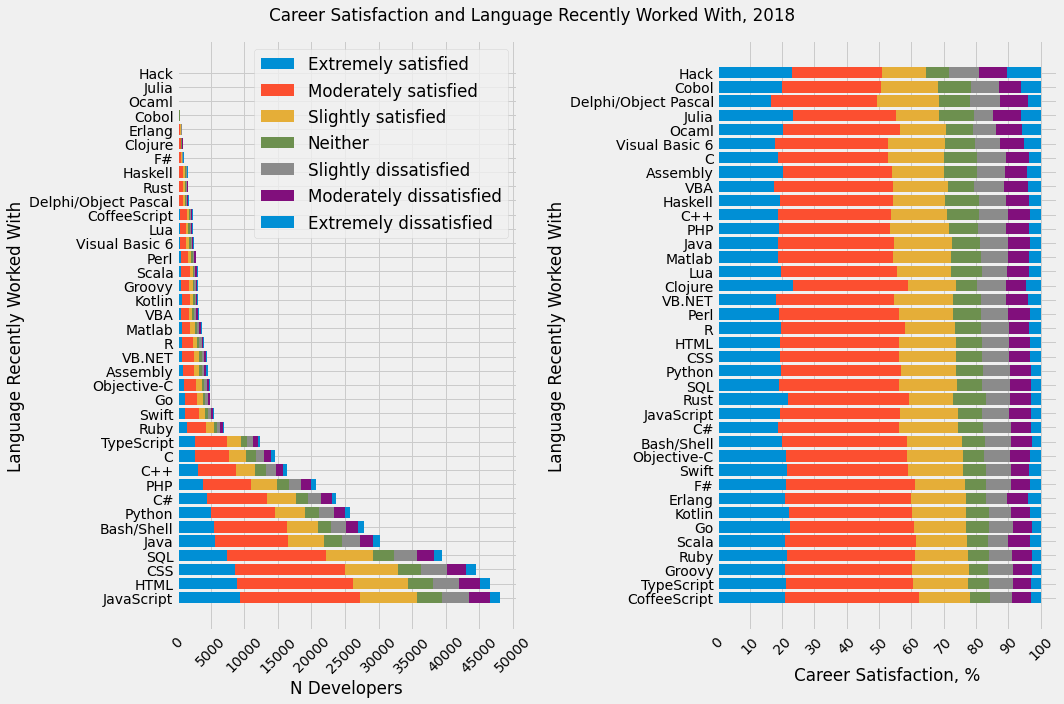

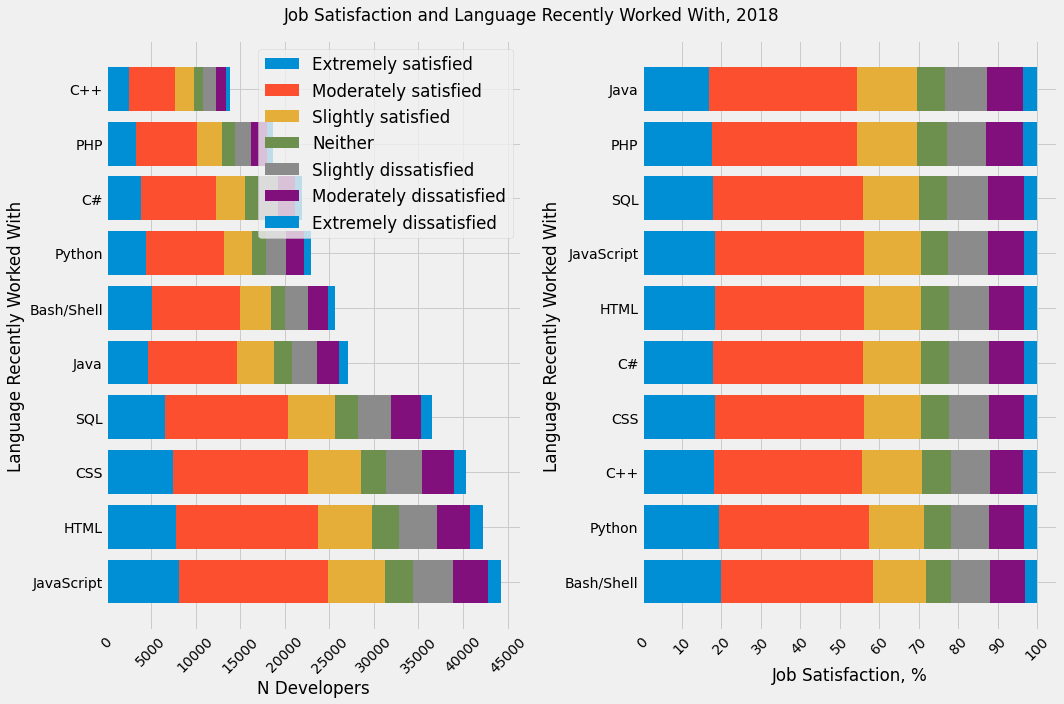

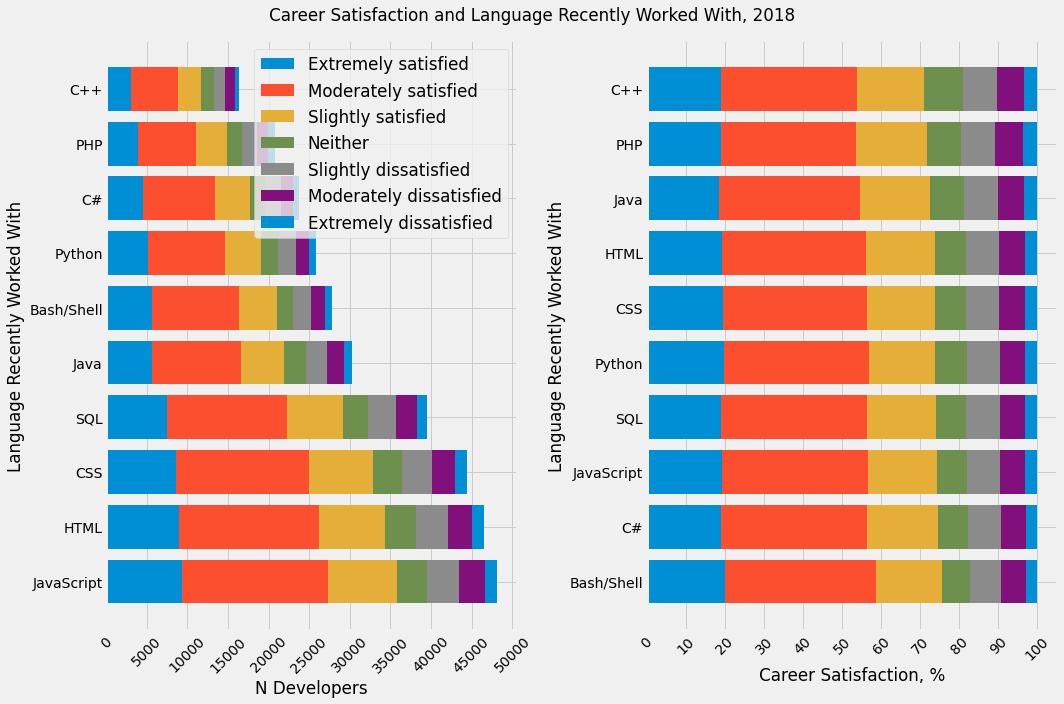

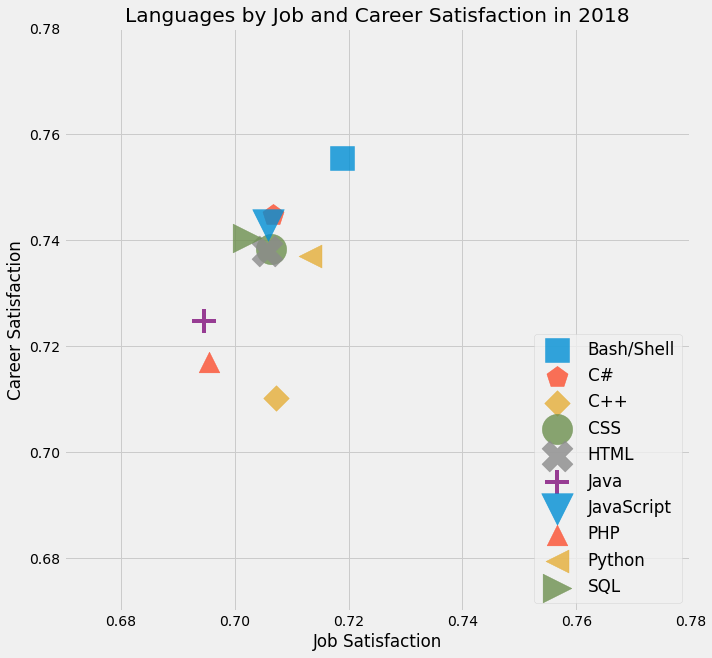

In [23]:
columns_sorted_2018 = [
    'Extremely satisfied',
    'Moderately satisfied',
    'Slightly satisfied',
    'Neither satisfied nor dissatisfied',
    'Slightly dissatisfied',
    'Moderately dissatisfied',
    'Extremely dissatisfied',
]

language_job_satisfaction_2018 = group_sat_lang(survey_2018, 'JobSatisfaction', 'LanguageWorkedWith', columns_sorted_2018)
language_career_satisfaction_2018 = group_sat_lang(survey_2018, 'CareerSatisfaction', 'LanguageWorkedWith', columns_sorted_2018)

plot_satisfaction_barh(language_job_satisfaction_2018, 'Job', '2018', columns_sorted_2018)
plot_satisfaction_barh(language_career_satisfaction_2018, 'Career', '2018', columns_sorted_2018)


"""
Exploring top 10 most used languages in 2018
"""
# Languages by job satisfaction
ljs_2018_total_top_10 = language_job_satisfaction_2018.loc[language_job_satisfaction_2018['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(ljs_2018_total_top_10, 'Job', '2018', columns_sorted_2018)

# Languages by career satisfaction
lcs_2018_total_top_10 = language_career_satisfaction_2018.loc[language_career_satisfaction_2018['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(lcs_2018_total_top_10, 'Career', '2018', columns_sorted_2018)

assert len(set(ljs_2018_total_top_10.index.tolist()).difference(lcs_2018_total_top_10.index.tolist())) == 0
plot_satisfaction_scatter(ljs_2018_total_top_10, lcs_2018_total_top_10, 
                          'Job Satisfaction', 'Career Satisfaction', 
                          'Languages by Job and Career Satisfaction in 2018')

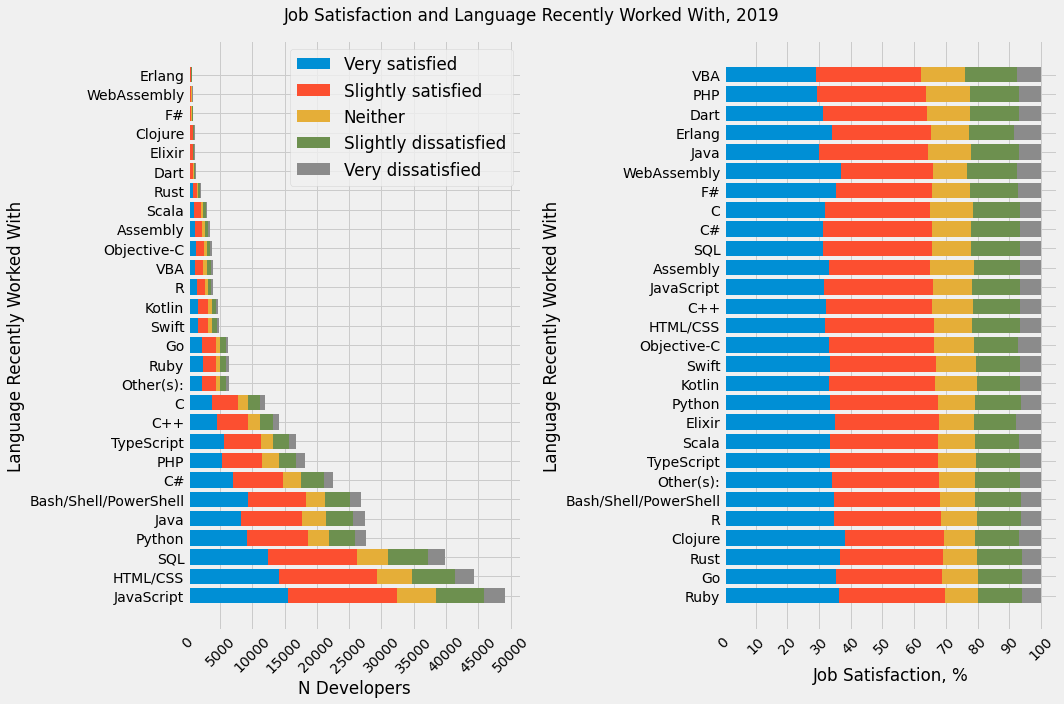

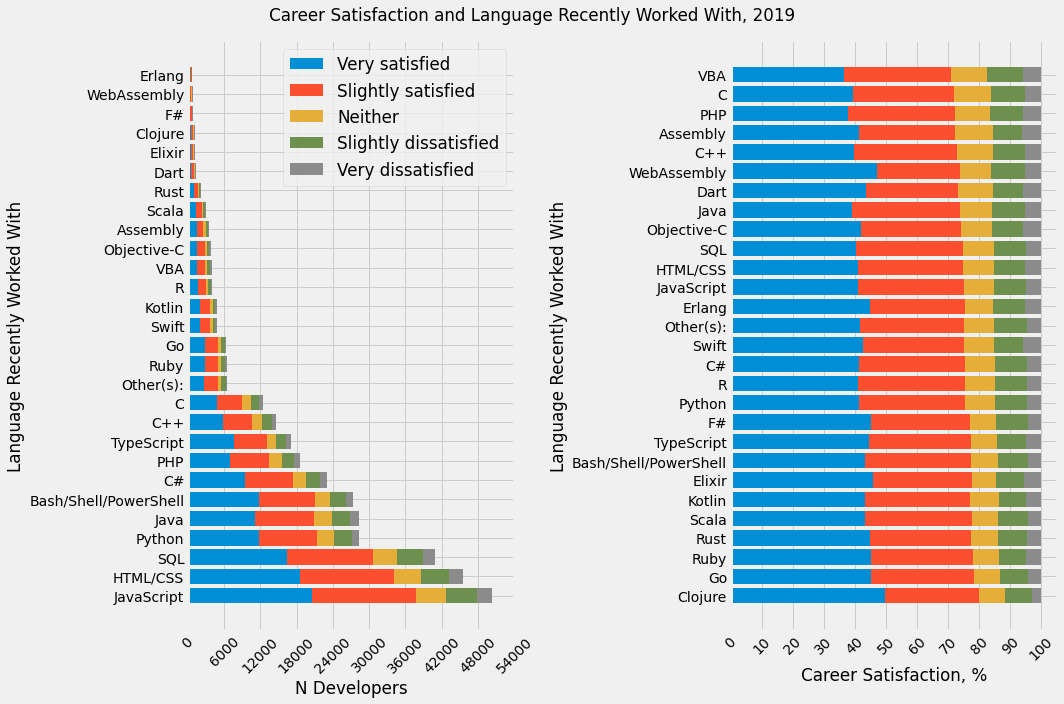

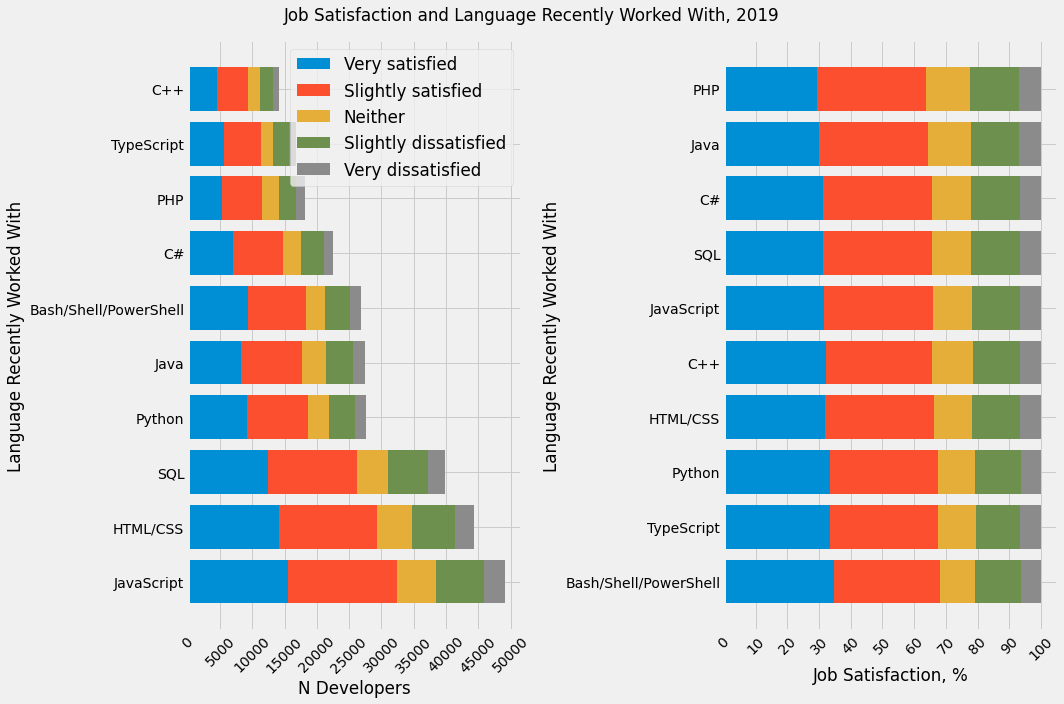

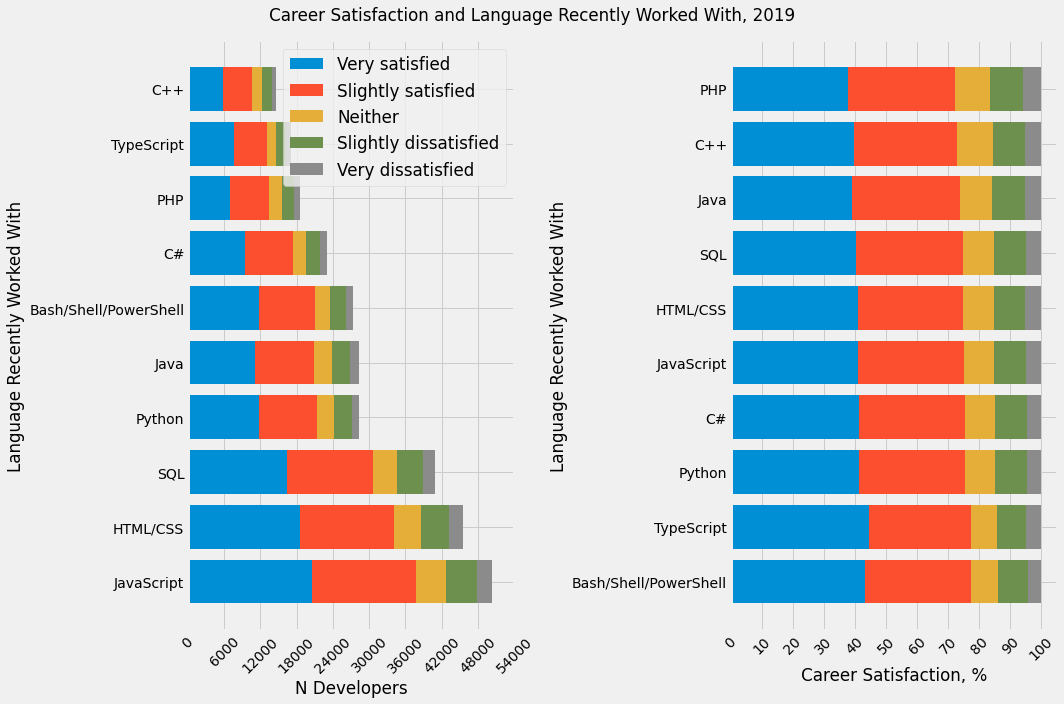

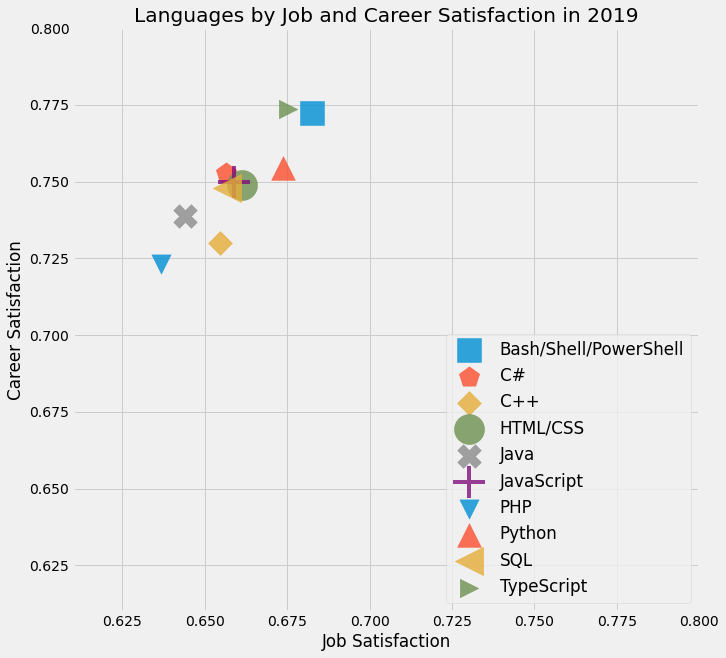

In [24]:
columns_sorted_2019 = [
    'Very satisfied',
    'Slightly satisfied',
    'Neither satisfied nor dissatisfied',
    'Slightly dissatisfied',
    'Very dissatisfied',
]

language_job_satisfaction_2019 = group_sat_lang(survey_2019, 'JobSat', 'LanguageWorkedWith', columns_sorted_2019)
language_career_satisfaction_2019 = group_sat_lang(survey_2019, 'CareerSat', 'LanguageWorkedWith', columns_sorted_2019)

plot_satisfaction_barh(language_job_satisfaction_2019, 'Job', '2019', columns_sorted_2019)
plot_satisfaction_barh(language_career_satisfaction_2019, 'Career', '2019', columns_sorted_2019)


"""
Exploring top 10 most used languages in 2019
"""
# Languages by job satisfaction
ljs_2019_total_top_10 = language_job_satisfaction_2019.loc[language_job_satisfaction_2019['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(ljs_2019_total_top_10, 'Job', '2019', columns_sorted_2019)

# Languages by career satisfaction
lcs_2019_total_top_10 = language_career_satisfaction_2019.loc[language_career_satisfaction_2019['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(lcs_2019_total_top_10, 'Career', '2019', columns_sorted_2019)

assert len(set(ljs_2019_total_top_10.index.tolist()).difference(lcs_2019_total_top_10.index.tolist())) == 0
plot_satisfaction_scatter(ljs_2019_total_top_10, lcs_2019_total_top_10, 
                          'Job Satisfaction', 'Career Satisfaction', 
                          'Languages by Job and Career Satisfaction in 2019')

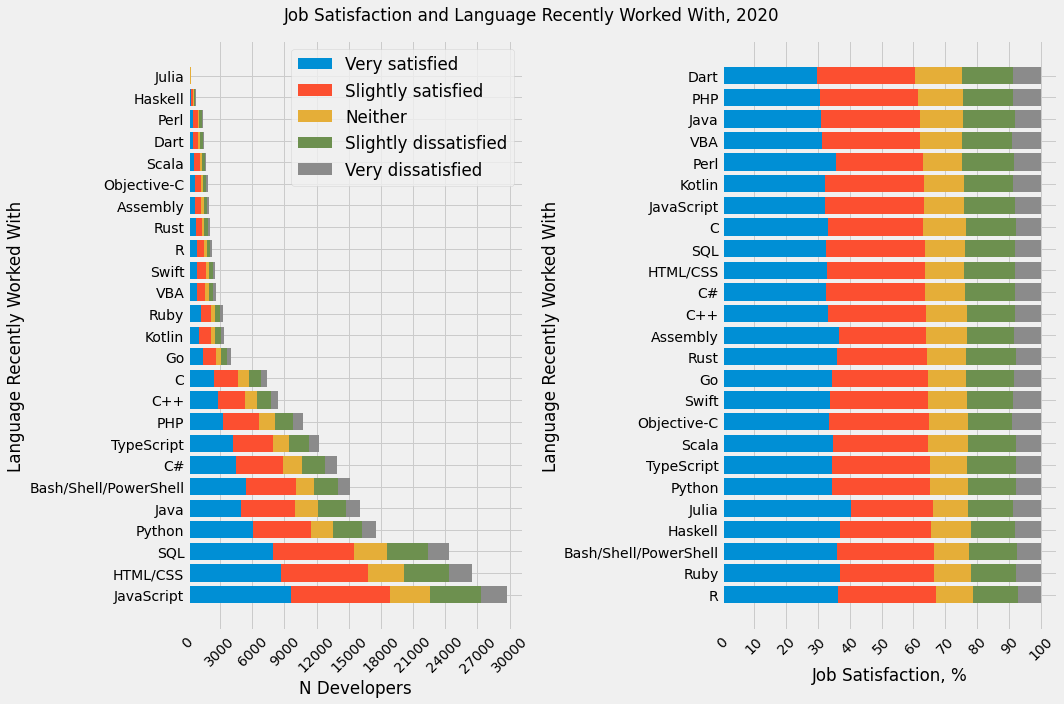

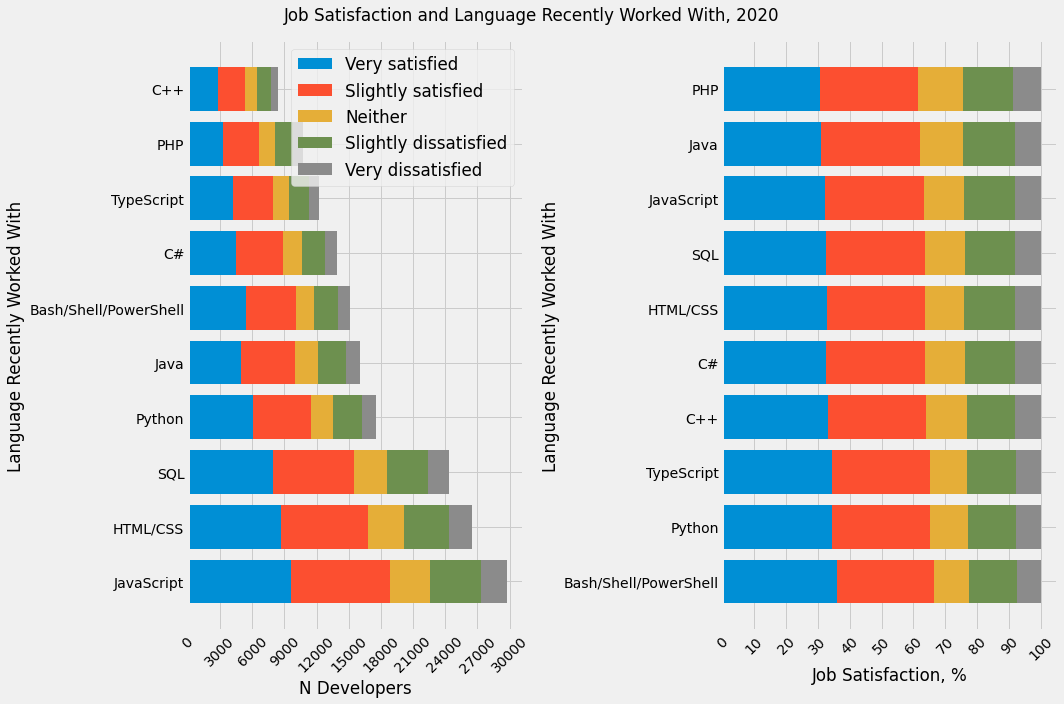

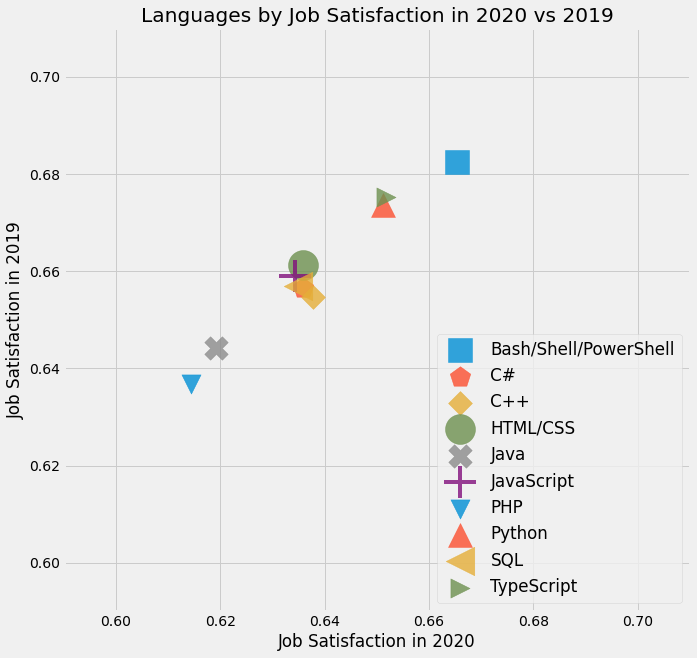

In [25]:
columns_sorted_2020 = [
    'Very satisfied',
    'Slightly satisfied',
    'Neither satisfied nor dissatisfied',
    'Slightly dissatisfied',
    'Very dissatisfied',
]

language_job_satisfaction_2020 = group_sat_lang(survey_2020, 'JobSat', 'LanguageWorkedWith', columns_sorted_2020)

plot_satisfaction_barh(language_job_satisfaction_2020, 'Job', '2020', columns_sorted_2020)


"""
Exploring top 10 most used languages in 2020
"""
# Languages by job satisfaction
ljs_2020_total_top_10 = language_job_satisfaction_2020.loc[language_job_satisfaction_2020['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(ljs_2020_total_top_10, 'Job', '2020', columns_sorted_2020)

# There is no career satisfaction column in 2020 survey
# Plotting Job Satisfaction in 2020 vs Job Satisfaction in 2019
assert len(set(ljs_2020_total_top_10.index.tolist()).difference(ljs_2019_total_top_10.index.tolist())) == 0
plot_satisfaction_scatter(ljs_2020_total_top_10, ljs_2019_total_top_10, 
                          'Job Satisfaction in 2020', 'Job Satisfaction in 2019', 
                          'Languages by Job Satisfaction in 2020 vs 2019')


In [26]:
for idx, ljs in enumerate([ljs_2017_total_top_10, ljs_2018_total_top_10, ljs_2019_total_top_10]):
    difference = set(ljs_2020_total_top_10.index.tolist()).difference(ljs.index.tolist())
    print(f'Year: {idx+2017}, difference: {difference}')

Year: 2017, difference: {'Bash/Shell/PowerShell', 'HTML/CSS'}
Year: 2018, difference: {'Bash/Shell/PowerShell', 'HTML/CSS', 'TypeScript'}
Year: 2019, difference: set()


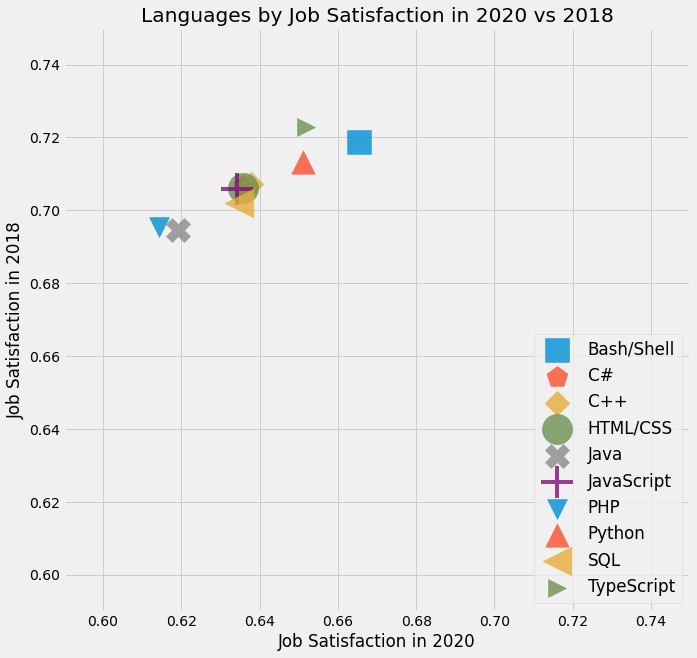

In [27]:
ljs_2020_total_top_10_for_2018 = ljs_2020_total_top_10.rename({'Bash/Shell/PowerShell': 'Bash/Shell'})
language_job_satisfaction_2018_for_2020 = language_job_satisfaction_2018.copy()
html_css = ((language_job_satisfaction_2018_for_2020.loc['HTML', :] + language_job_satisfaction_2018_for_2020.loc['CSS', :]) / 2)
html_css.name = 'HTML/CSS'
language_job_satisfaction_2018_for_2020 = language_job_satisfaction_2018_for_2020.append(html_css)

plot_satisfaction_scatter(ljs_2020_total_top_10_for_2018, 
                          language_job_satisfaction_2018_for_2020.loc[ljs_2020_total_top_10_for_2018.index.tolist(), :], 
                          'Job Satisfaction in 2020', 'Job Satisfaction in 2018', 
                          'Languages by Job Satisfaction in 2020 vs 2018')

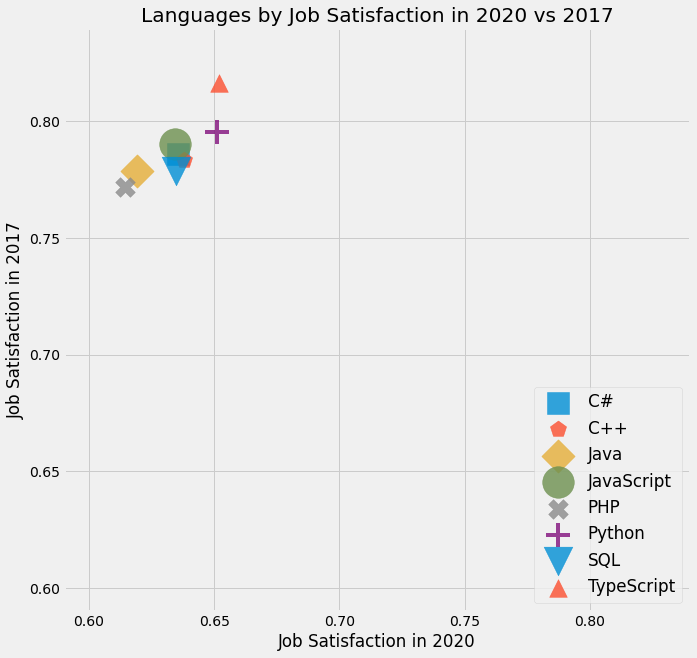

In [28]:
ljs_2020_total_top_10_for_2017 = ljs_2020_total_top_10.copy()
# None of 'HTML', 'CSS', 'Bash/Shell/PowerShell' in 2017 year's data
ljs_2020_total_top_10_for_2017 = ljs_2020_total_top_10_for_2017.drop(index=['HTML/CSS', 'Bash/Shell/PowerShell'])
language_job_satisfaction_2017_for_2020 = language_job_satisfaction_2017.copy()

plot_satisfaction_scatter(ljs_2020_total_top_10_for_2017, 
                          language_job_satisfaction_2017_for_2020.loc[ljs_2020_total_top_10_for_2017.index.tolist(), :], 
                          'Job Satisfaction in 2020', 'Job Satisfaction in 2017', 
                          'Languages by Job Satisfaction in 2020 vs 2017')